In [1]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
#use RobustScaler for normalization
from sklearn.preprocessing import RobustScaler
# use for learning rate schedular
from tensorflow.keras.callbacks import ReduceLROnPlateau
#for early stopping
from tensorflow.keras.callbacks import EarlyStopping
#for l2 regularization
from tensorflow.keras.regularizers import l2
from collections import Counter
from sklearn.preprocessing import LabelEncoder

import time
import os

In [3]:

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Copy of accurate_augmented_heart_data.csv')

Mounted at /content/drive


In [4]:
x = df.drop("target", axis=1).values
y = df["target"].values


In [5]:
scaler = RobustScaler()
x_scaled = scaler.fit_transform(x)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
scaler = RobustScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [8]:
df.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [9]:
model = Sequential([
    Dense(256, kernel_regularizer=l2(0.001), input_shape=(x_train.shape[1],)),  # Increased neurons
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),


    Dense(32, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [10]:

optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [11]:

history = model.fit(x_train, y_train, epochs=75, batch_size=50, validation_data=(x_test, y_test),callbacks=[early_stopping], verbose=1)


Epoch 1/75
180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6587 - loss: 0.9664 - val_accuracy: 0.8101 - val_loss: 0.8166
Epoch 2/75
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8014 - loss: 0.7671 - val_accuracy: 0.8548 - val_loss: 0.6764
Epoch 3/75
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8251 - loss: 0.7258 - val_accuracy: 0.8619 - val_loss: 0.6467
Epoch 4/75
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8306 - loss: 0.7021 - val_accuracy: 0.8619 - val_loss: 0.6395
Epoch 5/75
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8308 - loss: 0.7031 - val_accuracy: 0.8633 - val_loss: 0.6317
Epoch 6/75
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8355 - loss: 0.6852 - val_accuracy: 0.8646 - val_loss: 0.6271
Epoch 7/75
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8324 - loss: 0.6884 - val_accuracy: 0.8668 - val_loss: 0.6225
Epoch 8/75
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8433 - loss: 0.6729 - val_accuracy: 0

In [12]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8828 - loss: 0.4430
Test Accuracy: 87.94%


In [13]:
x_train_pca = np.array(x_train)
y_train = np.array(y_train)
train_loss, train_accuracy = model.evaluate(x_train_pca, y_train)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8839 - loss: 0.4216
Train Accuracy: 88.48%


In [ ]:
 #train 83.93% test 86.97%
# increases train 84.14% test 85.71% after RobustScaler normalization of data
# after making dropot 0.2 the accuracy train 86.24% test 84.45%
# after making epoch 100 train 83.51% test 84.87%
# after making learning 0.001 train 84.66% test 85.29%
# after making dropout 0.001 and epoch 75 and batch size 16 train 87.50%  test 86.13%
# after making epoch 100 and batch size 32 train 88.45% test 87.82%
# after making epoch 75 and learning rate 0.001 train 89.60% test 88.66%
# after using leakyrelu and making epoch 75 and batch size 16 train  87.18% test 87.82%

In [14]:
y_pred = model.predict(x_test)
y_pred_labels = (y_pred > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred_labels))
print(classification_report(y_test, y_pred_labels))

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.8793565683646113
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1056
           1       0.88      0.89      0.89      1182

    accuracy                           0.88      2238
   macro avg       0.88      0.88      0.88      2238
weighted avg       0.88      0.88      0.88      2238



In [15]:

# Extract values from history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history.get('accuracy', history.history.get('acc'))  # Some versions use 'acc'
val_accuracy = history.history.get('val_accuracy', history.history.get('val_acc'))

epochs = range(1, len(loss) + 1)


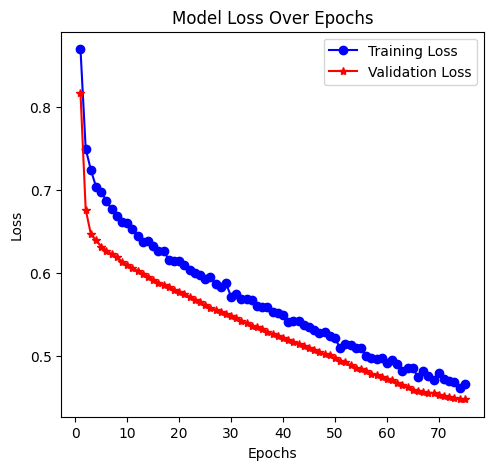

In [16]:
# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()


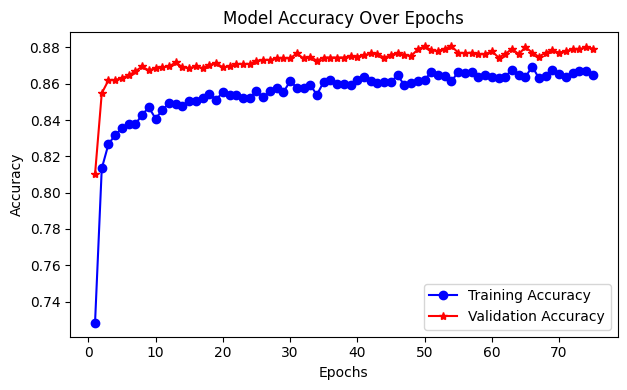

In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
import tensorflow as tf
import os
import time
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
from tensorflow.python.profiler import model_analyzer
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

def evaluate_model_metrics(model, x_test, y_test, model_name="model_metrics"):
    results = {}

    # Total Parameters
    results['total_parameters'] = model.count_params()

    # FLOPs Calculation
    func = tf.function(lambda x: model(x))
    concrete_func = func.get_concrete_function(
        tf.TensorSpec([1] + list(model.input_shape[1:]), model.inputs[0].dtype)
    )
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    flops = model_analyzer.profile(
        graph=frozen_func.graph,
        options=ProfileOptionBuilder.float_operation()
    ).total_float_ops
    results['FLOPs'] = flops
    results['GFLOPs'] = flops / 1e9

    # Model Size
    model_path = f"{model_name}.h5"
    model.save(model_path)
    size_bytes = os.path.getsize(model_path)
    results['model_size_bytes'] = size_bytes
    results['model_size_MB'] = size_bytes / (1024 * 1024)

    # Inference Time
    start = time.time()
    model.predict(x_test)
    end = time.time()
    results['inference_time_seconds'] = end - start

    # Accuracy
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    results['accuracy'] = acc

    return results
evaluate_model_metrics(model, x_test, y_test, model_name="model_metrics")



Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


{'total_parameters': 48257,
 'FLOPs': 96033,
 'GFLOPs': 9.6033e-05,
 'model_size_bytes': 658168,
 'model_size_MB': 0.6276779174804688,
 'inference_time_seconds': 0.2000272274017334,
 'accuracy': 0.8793565630912781}